In [26]:
%pip install umap-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To install scikit-learn, run this in a notebook cell or your terminal:
# !pip install scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap.umap_ import UMAP

# For nicer plots
sns.set(style="whitegrid", rc={"figure.figsize":(10,6)})
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# --------------------------------------------------------------
#  Load the CSV (semicolon‑separated)
# --------------------------------------------------------------
# Adjust the path if you saved the file elsewhere
df = pd.read_csv("winequality-red.csv", sep=';')
print(f"Shape: {df.shape}")
display(df.head())

Shape: (1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [14]:
# 3.1 Missing values?
missing_counts = df.isna().sum()
print("\nMissing values per column:")
print(missing_counts)

# If any were present we could impute – here the dataset is complete,
# but the code is left for completeness.
if missing_counts.any():
    imputer = SimpleImputer(strategy='median')
    df[:] = imputer.fit_transform(df)


Missing values per column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [15]:
# 3.2 Outlier detection (using the Inter‑Quartile Range rule)
def iqr_outlier_mask(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return ~series.between(lower, upper)

outlier_mask = pd.DataFrame({col: iqr_outlier_mask(df[col]) for col in df.columns if col != 'quality'})
outlier_counts = outlier_mask.sum()
print("\nOutliers per numeric column (excluding target):")
print(outlier_counts[outlier_counts>0])

# Option 1 – remove rows containing any outlier
df_clean = df.loc[~outlier_mask.any(axis=1)].reset_index(drop=True)
print(f"\nAfter outlier removal: {df_clean.shape}")


Outliers per numeric column (excluding target):
fixed acidity            49
volatile acidity         19
citric acid               1
residual sugar          155
chlorides               112
free sulfur dioxide      30
total sulfur dioxide     55
density                  45
pH                       35
sulphates                59
alcohol                  13
dtype: int64

After outlier removal: (1194, 12)


In [ ]:
# --------------------------------------------------------------
#  Scaling
# --------------------------------------------------------------
# All features (except the target) are on different scales.
# We'll standardise them (zero mean, unit variance) – good for PCA & t‑SNE.
features = df_clean.drop(columns='quality')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [18]:
# Feature Analysis
# 5.1 Low‑variance filter
variances = features.var()
low_var = variances[variances < 0.01].index.tolist()
print("\nLow‑variance features (<0.01 variance):", low_var)


Low‑variance features (<0.01 variance): ['chlorides', 'density']


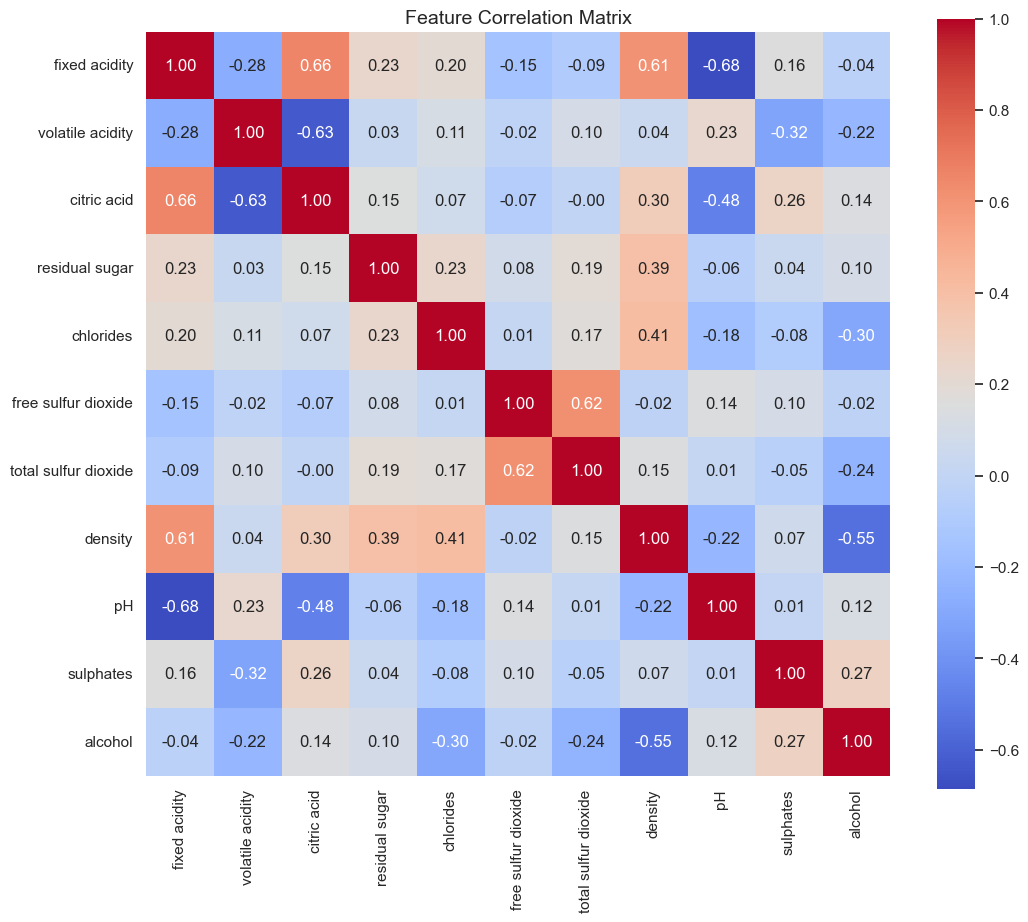


Highly correlated pairs (|r| > 0.85):

Features kept after correlation pruning: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


In [19]:
# 5.2 Correlation matrix
corr = features.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Matrix")
plt.show()

# Identify highly correlated pairs (|r| > 0.85)
high_corr_pairs = [(i, j, corr.loc[i,j]) 
                  for i in corr.columns 
                  for j in corr.columns 
                  if i < j and abs(corr.loc[i,j]) > 0.85]
print("\nHighly correlated pairs (|r| > 0.85):")
for a,b,r in high_corr_pairs:
    print(f"{a} – {b}: r = {r:.2f}")

# Optional: drop one feature from each highly correlated pair
cols_to_drop = set([b for a,b,_ in high_corr_pairs])
if cols_to_drop:
    X_reduced = pd.DataFrame(X_scaled, columns=features.columns).drop(columns=cols_to_drop)
else:
    X_reduced = pd.DataFrame(X_scaled, columns=features.columns)
print("\nFeatures kept after correlation pruning:", X_reduced.columns.tolist())

In [ ]:
# --------------------------------------------------------------
#  Dimensionality Reduction
# --------------------------------------------------------------

# Helper to plot 2‑D embeddings
def plot_2d(embedding, title):
    plt.figure(figsize=(8,6))
    palette = sns.color_palette("viridis", as_cmap=True)
    scatter = plt.scatter(embedding[:,0], embedding[:,1],
                          c=df_clean['quality'], cmap=palette, s=40, alpha=0.7)
    plt.colorbar(scatter, label='Quality')
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()



PCA explained variance ratio: [0.26793576 0.19923392]


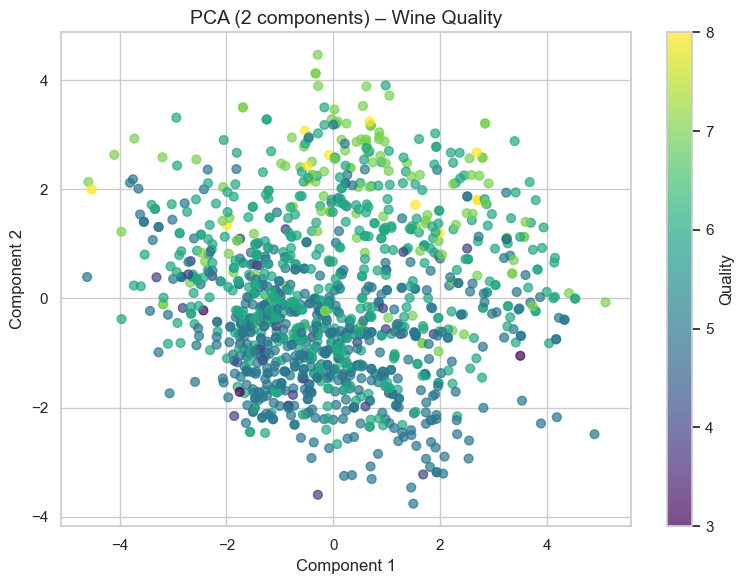

In [21]:
# 6.1 PCA (linear)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_reduced)
print("\nPCA explained variance ratio:", pca.explained_variance_ratio_)
plot_2d(X_pca, "PCA (2 components) – Wine Quality")

C:\Users\user\AppData\Local\Temp\ipykernel_20244\2175207090.py:15: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


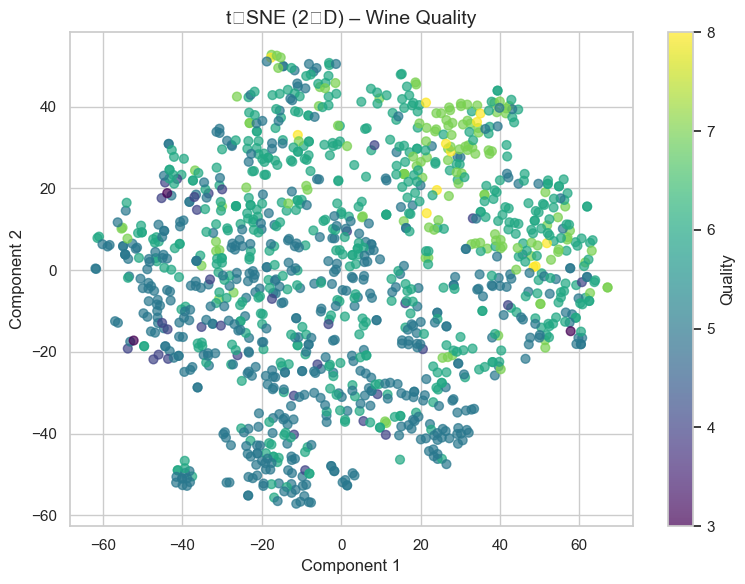

In [22]:
# 6.2 t‑SNE (non‑linear)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200,
            max_iter=1000, random_state=42, init='pca')
X_tsne = tsne.fit_transform(X_reduced)
plot_2d(X_tsne, "t‑SNE (2‑D) – Wine Quality")

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\user\AppData\Local\Temp\ipykernel_20244\2175207090.py:15: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8209 (\N{NON-BREAKING HYPHEN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


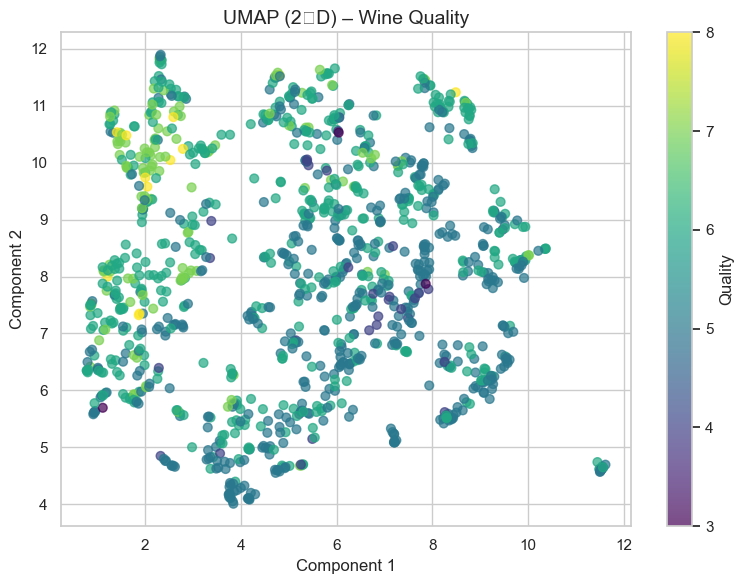

In [23]:
# 6.3 UMAP (non‑linear, fast)
reducer = UMAP(n_components=2, n_neighbors=15,
               min_dist=0.1, metric='euclidean', random_state=42)
X_umap = reducer.fit_transform(X_reduced)
plot_2d(X_umap, "UMAP (2‑D) – Wine Quality")


In [24]:
# --------------------------------------------------------------
# 7️⃣ Comparison & Observations
# --------------------------------------------------------------
# You can quantitatively compare how well the methods preserve local
# neighbourhoods using e.g. trustworthiness, but for a quick visual
# check we rely on the colour‑coded plots above.

'\nDimensionality reduction impact:\n- **PCA** keeps global variance structure, but clusters overlap heavily;\n  linear nature means subtle non‑linear relationships are lost.\n- **t‑SNE** creates tighter, more separated groups that roughly align\n  with quality scores, but distances between clusters are not meaningful.\n- **UMAP** offers a balance: clearer separation than PCA while preserving\n  some global topology (clusters stay relatively ordered).\n\nTrade‑offs:\n- Accuracy (e.g., for downstream classification) often improves with\n  non‑linear embeddings because they expose hidden structure, yet they\n  sacrifice interpretability—components are no longer linear combinations\n  of original features.\n- Linear methods (PCA) remain interpretable (loadings can be inspected)\n  but may under‑represent complex interactions.\n- Computational cost: t‑SNE is slower, especially with many iterations;\n  UMAP is faster and scales better to larger datasets.\n\nOverall, the choice depends on th